<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

---

## Extract data from Region Of Interest (ROI)

The present jupyter notebook contains the code to extract the zscores, effect size, residuals and timesiries from predefined ROIs. These regions of interest are dependant on the stimulation location and are specified in the metadata file. 

Follow the code step-wise. 

In [1]:
# --- Imports ---
import os
import glob
import nilearn
import numpy as np
import pandas as pd
import nibabel as nib

from numpy import savetxt
from nilearn import plotting
from nilearn.maskers import NiftiMasker

**Select the hemodynamic response function!** 

To input the corresponding data. 

In [18]:
# --- Path to input / output data ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    spm
    glover
    Two_gammas
    Peak_span
"""
#hrf_function = 'glover'
hrf_function = 'spm'
#hrf_function = 'Two_gammas'
#hrf_function = 'Peak_span'
#hrf_function = 'block'

print('Fetch the data from the first level analysis that used:', hrf_function)

Fetch the data from the first level analysis that used: spm


**Define input and output directories.**

In [19]:
# --- Init Variables ---
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

# --- Load templates and atlas --- 
template_folder = '/groupshare/traaffneu/preclinimg/templates/'
template_path = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
atlas_img = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_rs.nii')
atlas_labels = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt'
label_info = np.genfromtxt(atlas_labels, skip_header=10, delimiter='\t', dtype=str)
atlas_mask = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii')

# --- Output directories --- 

if hrf_function == 'glover':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
elif hrf_function == 'spm':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
elif hrf_function == 'Two_gammas':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/'
elif hrf_function == 'Peak_span':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/'
elif hrf_function == 'block':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/block/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/block/'
    
else:
    print('Define hrf_function.')

subdirectories = ['mask_ROIs']
zscores_dir = os.path.join(output_dir, 'mask_ROIs/z_scores/')
residuals_dir = os.path.join(output_dir, 'mask_ROIs/residuals/')
real_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/real_timeseries/')

for subdir in subdirectories:
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['z_scores', 'residuals', 'real_timeseries']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

**Let's extract the data!**
1. The 'for' loop iterates through scans. First step is to define the subject numver and load the corresponding scan.
2. Load the outputs of the 1st level analysis. 
3. Take the ROI(s) label in the metadata and find its equivalent index in the atlas. If there are two labels (right/left), they will be conjointly processed. 
4. Create a mask out of the selected ROI(s), fit it to the functional image and extract the signal from the ROI(s).
5. Save outputs.

>Note: extracting each type of signal can be very memory intensive and time consuming. 

In [20]:
# --- Extract data from ROI ---

for scan in range(20, len(df)):         
     
    subj_num=str(df.iloc[scan]['rat.sub'])  #[:-2]
    ses=str(df.iloc[scan]['rat.ses'])
    print('index:', scan)
    print('subj:', subj_num)
    print('ses', ses)

    subj_img_glob = glob.glob(f'/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{subj_num}_ses-{ses}/bold_datasink/commonspace_bold/*/*/*.nii.gz')[0]
    subj_img = nib.load(subj_img_glob)
    
    # --- Load 1-level analysis outputs ---  
    zscores_file = nib.load(first_level_output +f'z_score/z_score_sub-0{subj_num}_ses-{ses}.nii.gz')
    residuals_file = nib.load(first_level_output +f'residuals/residuals_sub-0{subj_num}_ses-{ses}.nii.gz')
    beta_estimates_file = nib.load(first_level_output + f'beta_estimates/beta_sub-0{subj_num}_ses-{ses}.nii.gz')   

    # --- Define the ROI --- 
    labels_dict = {row[-1].strip('"'): int(row[0]) for row in label_info}       # Creates a dictionary with the atlas_label as the key and the label index as the value.
    labels = ['roi_right','roi_left']                                           # Create table with 2 columns, named as in the metadata
    label_indices = []                                                          # create an empty list 
    
    for label in labels:                                                        # Loop iterates through the elements in the labels list.
        atlas_label = df.iloc[scan][label]                                      # Extracts the value in the metadata dataframe, for 1 subject
        print(atlas_label)
        label_indices.append(labels_dict.get(atlas_label))                      # Appends the atlas_label index to the array to search for it later

    # --- Generate the ROI(s) masks --- 
    roi_mask = np.isin(nilearn.image.get_data(atlas_img), label_indices)        # To create the mask, select ROI(s) based on the index
    roi_mask = roi_mask.astype(bool)                                        

    roi_mask_img = nilearn.image.new_img_like(atlas_img, roi_mask)              # Create a mask image out of the roi selected
    masker = NiftiMasker(mask_img=roi_mask_img).fit(subj_img)                   # Fit the mask on the functional image
    masker_stand = NiftiMasker(mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)

    # --- Extract data from the ROI(s)
    residuals = masker.fit_transform(residuals_file)
    print("Done residuals")
    real_timeseries = masker.fit_transform(subj_img)
    print("Done real_timeseries")
    z_scores = masker.fit_transform(zscores_file)                             
    print("Done z_scores")

    # --- Save outputs --- 
    savetxt(residuals_dir+f'residuals_sub-0{subj_num}_ses-1.csv', residuals, delimiter=',') 
    savetxt(real_timeseries_dir+f'real_timeseries_sub-0{subj_num}_ses-1.csv', real_timeseries, delimiter=',') 
    savetxt(zscores_dir+f'zscores_sub-0{subj_num}_ses-1.csv', z_scores, delimiter=',')     
      
    print("Done Saving")

index: 20
subj: 200301
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 21
subj: 200302
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 22
subj: 200303
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 23
subj: 200304
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 24
subj: 200305
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 25
subj: 200306
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 26
subj: 200307
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 27
subj: 200308
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 28
subj: 200400
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 29
subj: 200401
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 30
subj: 200402
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 31
subj: 200403
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 32
subj: 200404
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 33
subj: 200405
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 34
subj: 200406
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 35
subj: 200407
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 36
subj: 200408
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 37
subj: 200409
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 38
subj: 200500
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 39
subj: 200501
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 40
subj: 200502
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 41
subj: 200503
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 42
subj: 200504
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 43
subj: 200505
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 44
subj: 200506
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 45
subj: 200507
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 46
subj: 200508
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 47
subj: 200509
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 48
subj: 200600
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 49
subj: 200601
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 50
subj: 200602
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 51
subj: 200603
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 52
subj: 200604
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 53
subj: 200605
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 54
subj: 200606
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 55
subj: 200607
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 56
subj: 200608
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 57
subj: 200609
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 58
subj: 200700
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 59
subj: 200701
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 60
subj: 200702
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 61
subj: 200703
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 62
subj: 200704
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 63
subj: 200705
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 64
subj: 200706
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 65
subj: 200707
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 66
subj: 200800
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 67
subj: 200801
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 68
subj: 200802
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 69
subj: 200803
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 70
subj: 200804
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 71
subj: 200805
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 72
subj: 200806
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 73
subj: 200807
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 74
subj: 200808
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 75
subj: 200900
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 76
subj: 200901
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 77
subj: 200902
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 78
subj: 200903
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 79
subj: 200904
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 80
subj: 200905
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 81
subj: 200906
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 82
subj: 200907
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 83
subj: 200908
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 84
subj: 200909
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 85
subj: 201000
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 86
subj: 201001
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 87
subj: 201002
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 88
subj: 201003
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 89
subj: 201004
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 90
subj: 201005
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 91
subj: 201006
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 92
subj: 201007
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 93
subj: 201008
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 94
subj: 201009
ses 1
nan
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 95
subj: 201100
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 96
subj: 201101
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 97
subj: 201102
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 98
subj: 201103
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 99
subj: 201104
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 100
subj: 201105
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 101
subj: 201106
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 102
subj: 201107
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 103
subj: 201108
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 104
subj: 201109
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 105
subj: 201200
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 106
subj: 201201
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 107
subj: 201202
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 108
subj: 201203
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 109
subj: 201204
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 110
subj: 201205
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 111
subj: 201206
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 112
subj: 201207
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 113
subj: 201208
ses 1
Primary Somatosensory Cortex Hindlimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 114
subj: 201300
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 115
subj: 201301
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 116
subj: 201302
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 117
subj: 201303
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 118
subj: 201304
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 119
subj: 201305
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 120
subj: 201306
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 121
subj: 201307
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 122
subj: 201308
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 123
subj: 201309
ses 1
Primary Somatosensory Cortex Forelimb-R
Primary Somatosensory Cortex Forelimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 124
subj: 201400
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 125
subj: 201402
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 126
subj: 201403
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 127
subj: 201404
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 128
subj: 201405
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 129
subj: 201406
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 130
subj: 201407
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 131
subj: 201408
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 132
subj: 201409
ses 1
Primary Somatosensory Cortex Hindlimb-R
Primary Somatosensory Cortex Hindlimb-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 133
subj: 201500
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 134
subj: 201501
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 135
subj: 201502
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 136
subj: 201503
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 137
subj: 201504
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 138
subj: 201505
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 139
subj: 201506
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 140
subj: 201507
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 141
subj: 201508
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 142
subj: 201509
ses 1
Primary Somatosensory Cortex Barrel field-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 143
subj: 201600
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 144
subj: 201601
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 145
subj: 201602
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 146
subj: 201604
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 147
subj: 201605
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 148
subj: 201606
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 149
subj: 201607
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 150
subj: 201608
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 151
subj: 201609
ses 1
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 152
subj: 201700
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 153
subj: 201701
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 154
subj: 201702
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 155
subj: 201703
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 156
subj: 201704
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 157
subj: 201705
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 158
subj: 201706
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 159
subj: 201707
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 160
subj: 201708
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 161
subj: 201709
ses 2
Deeper Layers of the Superior Colliculus-R
Deeper Layers of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 162
subj: 201800
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 163
subj: 201801
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 164
subj: 201802
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 165
subj: 201803
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 166
subj: 201804
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 167
subj: 201805
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 168
subj: 201807
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 169
subj: 201808
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 170
subj: 201809
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 171
subj: 201900
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 172
subj: 201901
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 173
subj: 201902
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 174
subj: 201903
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 175
subj: 201904
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 176
subj: 201905
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 177
subj: 201908
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 178
subj: 201909
ses 1
Primary Somatosensory Cortex Forelimb-R
nan


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 179
subj: 202000
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 180
subj: 202001
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 181
subj: 202002
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 182
subj: 202003
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 183
subj: 202004
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 184
subj: 202005
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 185
subj: 202006
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 186
subj: 202007
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 187
subj: 202008
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 188
subj: 202009
ses 4
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 189
subj: 202100
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 190
subj: 202101
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 191
subj: 202102
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 192
subj: 202103
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 193
subj: 202104
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 194
subj: 202105
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 195
subj: 202106
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 196
subj: 202107
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 197
subj: 202108
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 198
subj: 202109
ses 4
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 199
subj: 202200
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 200
subj: 202201
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 201
subj: 202202
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 202
subj: 202203
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 203
subj: 202204
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 204
subj: 202205
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 205
subj: 202206
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 206
subj: 202207
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 207
subj: 202208
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 208
subj: 202209
ses 4
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving


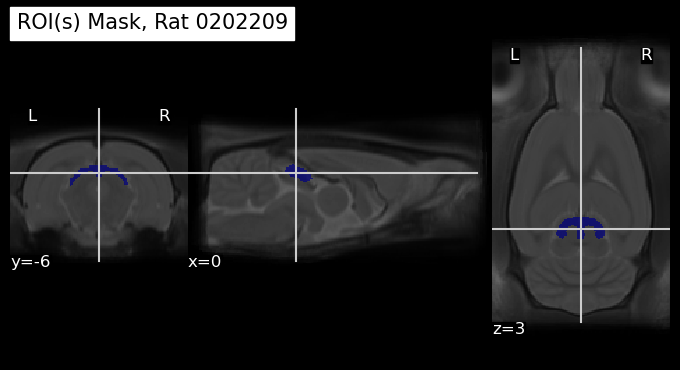

In [21]:
# --- Check the mask --- 
plotting.plot_roi(roi_mask_img, bg_img=template_path, title=f"ROI(s) Mask, Rat 0{subj_num}")